<a href="https://colab.research.google.com/github/mdziecielski/Machine-Translation-Challenge/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI4D Takwimu Lab - Machine Translation Challenge

https://zindi.africa/competitions/ai4d-takwimu-lab-machine-translation-challenge

## Goal

The objective of this challenge is to create a machine translation system capable of converting text from French into Fongbe or Ewe. You may train one model per language or create a single model for both. You may not use any external data, so a key component of this competition is finding a way to work with the available data efficiently.

## Data

Files:
* Train.csv - contains parallel sentences for training your model or models. There are 77,177 rows, of which 53,366 are French-Fongbe and 23,811 are French-Ewe
* Test.csv- resembles Train.csv but without the Target column. This is the dataset on which you will apply your model(s).
* SampleSubmission.csv - shows the submission format for this competition, with the ID column mirroring that of Test.csv and the ‘Target’ column containing your translation in Ewe or Fongbe. The order of the rows does not matter, but the names of the ‘ID’ must be correct.

Variables:
* ID : Unique identifier of the text
* French : Text in French
* Target_Laguauge: The target language
* Target : Text in Fongbe or Ewe

## Evaluation

The error metric for this competition is the BLEU score. The BLEU score is a way of evaluating machine translations by comparing a candidate translation with one or more reference translations. There is no perfect metric for machine translation, but the BLEU score is useful for the following reasons:
* BLEU scores tend to correlate well with human evaluations of translations
* BLEU is an extremely common metric
* Computing the BLEU score is relatively simple and it is well-supported by various libraries

However, there are some caveats worth noting:
* BLEU scores are not always comparable across different datasets. In particular, the BLEU score is very dependent on the number of reference translations available. A low score on a dataset with only one reference translation for each input (such as the one in this competition) does not necessarily imply a worse model than one which gets a high score on a different dataset. This makes it hard to directly compare with other models based on BLEU score alone.
* The BLEU score looks at words which the candidate translation and the reference have in common. This can cause issues, especially for agglutinative

## Deadline

**31 May 2021**

## Sources
* https://stackabuse.com/python-for-nlp-neural-machine-translation-with-seq2seq-in-keras/
* https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
* https://stackoverflow.com/questions/50915634/multilayer-seq2seq-model-with-lstm-in-keras

## Papers
* [Regularization techniques for fine-tuning in neural machine translation](https://arxiv.org/abs/1707.09920)
* [SwitchOut: an Efficient Data Augmentation Algorithm for Neural Machine Translation](https://arxiv.org/abs/1808.07512)

## To-dos


1.   Overfitting
  * Decrease model size (LSTM and Embedding)
  * L2 regularization
  * Add dropout layers
4.   Data augmentation
5.   K-fold validation
6.   Stack multiple LSTMs?
7.   Split data into train, val and test - test using BLEU score


---


# Load data and import libraries

In [ ]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from tqdm.notebook import trange
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.layers import Input, Embedding, LSTM, Dense
from keras.regularizers import l2
from matplotlib import pyplot as plt
from google.colab import drive

drive.mount('/content/drive')
main_dir = '/content/drive/MyDrive/Side projects/AI4D Takwimu Lab - Machine Translation Challenge/'

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv(main_dir + 'Train.csv')
test_df = pd.read_csv(main_dir + 'Test.csv')
jw300_fon = pd.read_csv(main_dir + 'fon-fr.csv')

In [ ]:
train_df

,ID,French,Target_Language,Target
0,ID_AADNDxdl,Mon père,Fon,Tɔ ce
1,ID_AAFQhmDr,Mettez-vous en rang.,Fon,Mi tò miɖéé
2,ID_AAHVDMdq,"Sénégal, Côte d'Ivoire, Guinée, Ghana, on déco...",Ewe,"Sénégal, Côte d'Ivoire, Guinée, Ghana, siwo ƒe..."
3,ID_AAJfVHEH,Son doigt lui fait mal.,Fon,Alɔvi tɔn ɖo vivɛ wɛ
4,ID_AAOJuhzN,La pluie a commencé.,Fon,Jì bɛ́
...,...,...,...,...
75482,ID_zzsOfbtD,Reconduis-le.,Fon,Kpl’ɛ́ yì
75483,ID_zztJChgi,Le vent pousse le nuage,Fon,Jɔhɔn ɔ ɖo akpɔkpɔ sisε wε.
75484,ID_zztqxmJe,"Si mon mari conduit, c’est que ce n’est pas lo...",Fon,"Nu asu ce kun hun ɔ, hun e lin a nε"
75485,ID_zzxVgzgw,"Cette année, je vais épouser celle-là.",Fon,"Xwe elɔ mɛ, un na wli alɔ x’ɛ"


In [ ]:
test_df

,ID,French,Target_Language
0,ID_AAAAhgRX,Très fière d’elle,Ewe
1,ID_AAGuzGzi,Tous ces grands artistes viendront au Benin po...,Fon
2,ID_AAuiTPkQ,Ce programme va travailler à améliorer les con...,Fon
3,ID_ACYgGXTq,Quels sont les questions récurrentes de ceux ...,Fon
4,ID_AChdWHyF,Grosse bagnolle,Ewe
...,...,...,...
5888,ID_zwUBSGbf,On a encore du chemin à faire,Ewe
5889,ID_zwXoHFXd,Servez moi un verre de sodabi que je vais boire,Fon
5890,ID_zxgfwvGY,"Aujourd’hui, la science n’a pas fini de percer...",Ewe
5891,ID_zyWQSnnG,Il n’a pas rêvé.,Fon


In [ ]:
jw300_fon

,fon,fr
0,XOTA E ÐÒ AKPÀ Ɔ JÍ É | ETƐWU MǏ KA ÐÓ NA NƆ ...,EN COUVERTURE | POURQUOI ÊTRE HONNÊTE ?\n
1,Hitoshi nɔ w’azɔ̌ ɖò azɔ̌xɔsa akwɛlínlɛ́n tɔn ...,Hitoshi travaillait dans le service de la comp...
2,Hwenu e é ɖò akwɛzinzan ɖé lɛ́n xá gǎn tɔn wɛ ...,Alors qu’il examinait un rapport financier ave...
3,Hitoshi tinmɛ ɖɔ ayixa emitɔn kún na yí gbè bo...,Hitoshi a expliqué que sa conscience ne lui pe...
4,É sín enɛ wu bɔ gǎn ɔ gblɔ́n adǎn n’i ɖɔ emi n...,Il a alors été menacé de licenciement .\n
...,...,...
33357,\n,Et je continue à compter sur Jéhovah en le pri...
33358,Gbɛ̌dido xá mɛ ɖěɖee nɔ ɖ’alɔ ɖò sinsɛnzɔ́ ɔ s...,» Nous avons peut - être des faiblesses diffic...
33359,Un lɛ́ kpó ɖò ɖɛ xò sɛ́dó Jehovah wɛ bo ganjɛ ...,"Par exemple , perdre patience , nous mettre vi..."
33360,\n,"Lutter contre nos faiblesses , c’est continuer..."


In [ ]:
# Get rid of rows with no translation
# jw300_fon = jw300_fon.drop(jw300_fon[(jw300_fon.fon == '\n') | (jw300_fon.fr == '\n')].index)

# Rename columns
jw300_fon = jw300_fon.rename(columns={'fon': 'Target', 'fr': 'French'})

# Add 'Target_Language' column
jw300_fon['Target_Language'] = ['Fon'] * len(jw300_fon)

# Add to train_df
train_df = pd.concat([train_df, jw300_fon])

In [ ]:
train_df['output_sentence'] = train_df.apply(lambda row: row['Target'] + ' <end>', axis=1)
train_df['output_sentence_input'] = train_df.apply(lambda row: '<start> ' + row['Target'], axis=1)
train_df.drop(columns=['Target'], inplace=True)
train_df

KeyError: ignored

# Fongbe

## Parameters

In [ ]:
FONGBE_MAX_SENTENCES = 100000
FONGBE_MAX_NUM_WORDS = 50000
LSTM_SIZE = 512
EMBEDDING_SIZE = 200
BATCH_SIZE = 64
EPOCHS = 20

## Preprocessing

In [ ]:
fongbe_input_sentences = train_df[train_df['Target_Language'] == 'Fon']['French'].values[:FONGBE_MAX_SENTENCES]
fongbe_output_sentences = train_df[train_df['Target_Language'] == 'Fon']['output_sentence'].values[:FONGBE_MAX_SENTENCES]
fongbe_output_sentences_inputs = train_df[train_df['Target_Language'] == 'Fon']['output_sentence_input'].values[:FONGBE_MAX_SENTENCES]

fongbe_test_sentences = test_df[test_df['Target_Language'] == 'Fon']['French'].values[:FONGBE_MAX_SENTENCES]

In [ ]:
print(fongbe_input_sentences[100], fongbe_output_sentences[100], fongbe_output_sentences_inputs[100], fongbe_test_sentences[100], sep='\n')

J’allais chez lui.
Un nɔ yi gɔ́n tɔn ɖáyi <end>
<start> Un nɔ yi gɔ́n tɔn ɖáyi
Vous avez eu faim mais vous n’avez pas mangé parce qu’il n’y avait pas assez d’argent ou d’autres ressources pour vous procurer à manger


In [ ]:
def tokenize_input(sentences, test_sentences, max_num_words):
    input_tokenizer = Tokenizer(num_words=max_num_words)
    input_tokenizer.fit_on_texts(np.append(sentences, test_sentences))
    input_int_seq = input_tokenizer.texts_to_sequences(sentences)
    test_int_seq = input_tokenizer.texts_to_sequences(test_sentences)
    
    word2idx_inputs = input_tokenizer.word_index
    print('Unique words in the input:', len(word2idx_inputs))
    
    num_words = min(max_num_words, len(word2idx_inputs) + 1)
    
    max_input_len = max(len(s) for s in input_int_seq)
    max_test_len = max(len(s) for s in test_int_seq)
    max_input_len = max(max_input_len, max_test_len)

    print('Longest sentence length:', max_input_len)
    
    return input_int_seq, test_int_seq, max_input_len, num_words, word2idx_inputs

def tokenize_output(sentences, sentences_inputs, max_num_words):
    output_tokenizer = Tokenizer(num_words=max_num_words, filters='')
    output_tokenizer.fit_on_texts(np.append(sentences, sentences_inputs))
    output_int_seq = output_tokenizer.texts_to_sequences(sentences)
    output_input_int_seq = output_tokenizer.texts_to_sequences(sentences_inputs)
    
    word2idx_outputs = output_tokenizer.word_index
    print('Unique words in the output:', len(word2idx_outputs))
        
    num_words_output = len(word2idx_outputs) + 1
    max_output_len= max(len(s) for s in output_int_seq)
    print('Longest sentence length:', max_output_len)
    
    return output_int_seq, output_input_int_seq, max_output_len, num_words_output, word2idx_outputs

In [ ]:
fongbe_input_int_seq, fongbe_test_int_seq, fongbe_max_input_len, fongbe_num_words, fongbe_word2idx_inputs = tokenize_input(fongbe_input_sentences, fongbe_test_sentences, FONGBE_MAX_NUM_WORDS)
fongbe_output_int_seq, fongbe_output_input_int_seq, fongbe_max_output_len, fongbe_num_words_output, fongbe_word2idx_outputs = tokenize_output(fongbe_output_sentences, fongbe_output_sentences_inputs, FONGBE_MAX_NUM_WORDS)

Unique words in the input: 29354
Longest sentence length: 119
Unique words in the output: 19853
Longest sentence length: 173


In [ ]:
fongbe_encoder_input_sequences = pad_sequences(fongbe_input_int_seq, maxlen=fongbe_max_input_len)
fongbe_decoder_input_sequences = pad_sequences(fongbe_output_input_int_seq, maxlen=fongbe_max_output_len, padding='post')
fongbe_decoder_output_sequences = pad_sequences(fongbe_output_int_seq, maxlen=fongbe_max_output_len, padding='post')

fongbe_test_sequences = pad_sequences(fongbe_test_int_seq, maxlen=fongbe_max_input_len)

## Model

In [ ]:
X_train_fongbe_encoder, X_test_fongbe_encoder, X_train_fongbe_decoder, X_test_fongbe_decoder, y_train_fongbe, y_test_fongbe = train_test_split(fongbe_encoder_input_sequences, fongbe_decoder_input_sequences, fongbe_decoder_output_sequences, test_size=0.2)

In [ ]:
def generate_batch(X_encoder, X_decoder, y, batch_size, max_output_len, num_words_output):
    while True:
        for j in range(0, len(X_encoder), batch_size):
            X_encoder_batch = X_encoder[j:j+batch_size]
            X_decoder_batch = X_decoder[j:j+batch_size]
            y_one_hot_batch = np.zeros((len(X_encoder_batch), max_output_len, num_words_output),dtype='float32')

            for i, d in enumerate(y[j:j+batch_size]):
              for t, word in enumerate(d):
                y_one_hot_batch[i, t, word] = 1

            yield([X_encoder_batch, X_decoder_batch], y_one_hot_batch)


In [ ]:
encoder_inputs = Input(shape=(fongbe_max_input_len,))
x = Embedding(fongbe_num_words, EMBEDDING_SIZE)(encoder_inputs)
x, state_h, state_c = LSTM(LSTM_SIZE, return_state=True)(x)
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(fongbe_max_output_len,))
decoder_embedding = Embedding(fongbe_num_words_output, EMBEDDING_SIZE)
decoder_inputs_x = decoder_embedding(decoder_inputs)

decoder_lstm = LSTM(LSTM_SIZE, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

decoder_dense = Dense(fongbe_num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
fongbe_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
fongbe_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 119)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 173)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 119, 200)     5871000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 173, 200)     3970800     input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
fongbe_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
fongbe_history = fongbe_model.fit(
    generate_batch(X_train_fongbe_encoder, X_train_fongbe_decoder, y_train_fongbe, BATCH_SIZE, fongbe_max_output_len, fongbe_num_words_output),
    steps_per_epoch=math.ceil(len(X_train_fongbe_encoder)/BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=generate_batch(X_test_fongbe_encoder, X_test_fongbe_decoder, y_test_fongbe, BATCH_SIZE, fongbe_max_output_len, fongbe_num_words_output),
    validation_steps=math.ceil(len(X_test_fongbe_encoder)/BATCH_SIZE)
)

Epoch 1/20
1071/1071 [==============================] - 932s 839ms/step - loss: 0.6670 - accuracy: 0.9198 - val_loss: 0.3565 - val_accuracy: 0.9385
Epoch 2/20
1071/1071 [==============================] - 907s 847ms/step - loss: 0.3438 - accuracy: 0.9401 - val_loss: 0.3187 - val_accuracy: 0.9436
Epoch 3/20
1071/1071 [==============================] - 907s 847ms/step - loss: 0.3077 - accuracy: 0.9449 - val_loss: 0.2982 - val_accuracy: 0.9467
Epoch 4/20
1071/1071 [==============================] - 919s 858ms/step - loss: 0.2838 - accuracy: 0.9482 - val_loss: 0.2850 - val_accuracy: 0.9487
Epoch 5/20
1071/1071 [==============================] - 916s 855ms/step - loss: 0.2649 - accuracy: 0.9508 - val_loss: 0.2761 - val_accuracy: 0.9501
Epoch 6/20
1071/1071 [==============================] - 922s 861ms/step - loss: 0.2488 - accuracy: 0.9533 - val_loss: 0.2700 - val_accuracy: 0.9512
Epoch 7/20
1071/1071 [==============================] - 913s 853ms/step - loss: 0.2345 - accuracy: 0.9556 - val_

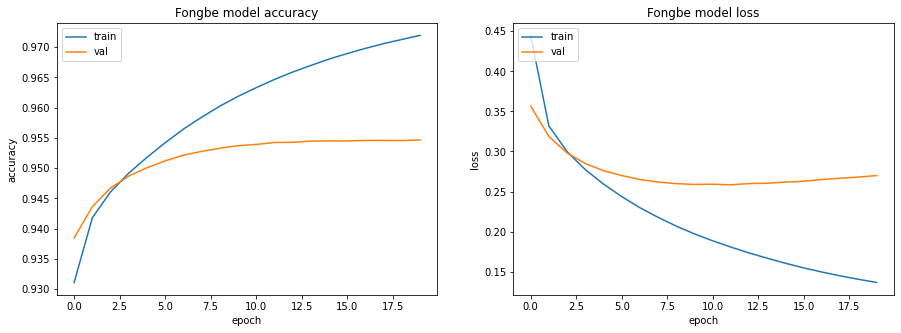

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(fongbe_history.history['accuracy'])
plt.plot(fongbe_history.history['val_accuracy'])
plt.title('Fongbe model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(fongbe_history.history['loss'])
plt.plot(fongbe_history.history['val_loss'])
plt.title('Fongbe model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [ ]:
fongbe_encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(LSTM_SIZE,))
decoder_state_input_c = Input(shape=(LSTM_SIZE,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
fongbe_decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [ ]:
fongbe_model.save(main_dir + 'fongbe.h5')
fongbe_encoder_model.save(main_dir + 'fongbe_encoder.h5')
fongbe_decoder_model.save(main_dir + 'fongbe_decoder.h5')

# Ewe

## Parameters

In [ ]:
EWE_MAX_SENTENCES = 30000
EWE_MAX_NUM_WORDS = 30000
LSTM_SIZE = 32
EMBEDDING_SIZE = 32
BATCH_SIZE = 64
EPOCHS = 5

## Preprocessing

In [ ]:
ewe_input_sentences = train_df[train_df['Target_Language'] == 'Ewe']['French'].values[:EWE_MAX_SENTENCES]
ewe_output_sentences = train_df[train_df['Target_Language'] == 'Ewe']['output_sentence'].values[:EWE_MAX_SENTENCES]
ewe_output_sentences_inputs = train_df[train_df['Target_Language'] == 'Ewe']['output_sentence_input'].values[:EWE_MAX_SENTENCES]

ewe_test_sentences = test_df[test_df['Target_Language'] == 'Ewe']['French'].values[:EWE_MAX_SENTENCES]

In [ ]:
ewe_input_int_seq, ewe_test_int_seq, ewe_max_input_len, ewe_num_words, ewe_word2idx_inputs = tokenize_input(ewe_input_sentences, ewe_test_sentences, EWE_MAX_NUM_WORDS)
ewe_output_int_seq, ewe_output_input_int_seq, ewe_max_output_len, ewe_num_words_output, ewe_word2idx_outputs = tokenize_output(ewe_output_sentences, ewe_output_sentences_inputs, EWE_MAX_NUM_WORDS)

Unique words in the input: 33913
Longest sentence length: 107
Unique words in the output: 28482
Longest sentence length: 66


In [ ]:
ewe_encoder_input_sequences = pad_sequences(ewe_input_int_seq, maxlen=ewe_max_input_len)
ewe_decoder_output_sequences = pad_sequences(ewe_output_int_seq, maxlen=ewe_max_output_len, padding='post')
ewe_decoder_input_sequences = pad_sequences(ewe_output_input_int_seq, maxlen=ewe_max_output_len, padding='post')

ewe_test_sequences = pad_sequences(ewe_test_int_seq, maxlen=ewe_max_input_len)

print(ewe_encoder_input_sequences.shape, ewe_test_sequences.shape, ewe_decoder_input_sequences.shape, ewe_decoder_output_sequences.shape)

(22353, 107) (2964, 107) (22353, 66) (22353, 66)


## Model

In [ ]:
X_train_ewe_encoder, X_test_ewe_encoder, X_train_ewe_decoder, X_test_ewe_decoder, y_train_ewe, y_test_ewe = train_test_split(ewe_encoder_input_sequences, ewe_decoder_input_sequences, ewe_decoder_output_sequences, test_size=0.2)

In [ ]:
encoder_inputs = Input(shape=(ewe_max_input_len,))
x = Embedding(ewe_num_words, EMBEDDING_SIZE)(encoder_inputs)
x, state_h, state_c = LSTM(LSTM_SIZE, return_state=True, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(ewe_max_output_len,))
decoder_embedding = Embedding(ewe_num_words_output, EMBEDDING_SIZE)
decoder_inputs_x = decoder_embedding(decoder_inputs)

decoder_lstm = LSTM(LSTM_SIZE, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

decoder_dense = Dense(ewe_num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
ewe_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
ewe_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
ewe_history = ewe_model.fit(
    generate_batch(X_train_ewe_encoder, X_train_ewe_decoder, y_train_ewe, BATCH_SIZE, ewe_max_output_len, ewe_num_words_output),
    steps_per_epoch=math.ceil(len(X_train_ewe_encoder)/BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=generate_batch(X_test_ewe_encoder, X_test_ewe_decoder, y_test_ewe, BATCH_SIZE, ewe_max_output_len, ewe_num_words_output),
    validation_steps=math.ceil(len(X_test_ewe_encoder)/BATCH_SIZE)
)

Epoch 1/5
280/280 [==============================] - ETA: 0s - loss: 6.8181 - accuracy: 0.5761

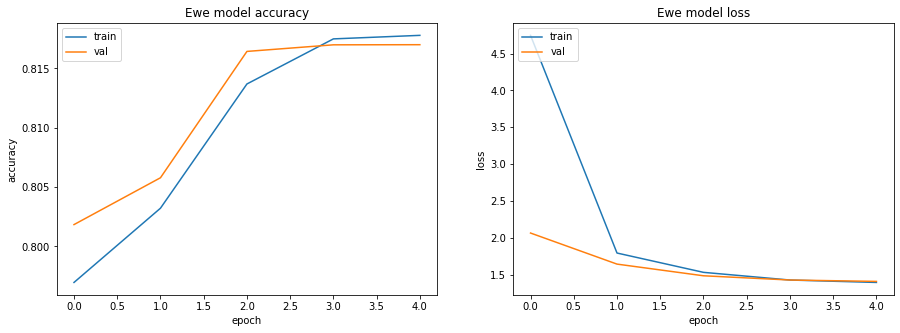

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(ewe_history.history['accuracy'])
plt.plot(ewe_history.history['val_accuracy'])
plt.title('Ewe model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(ewe_history.history['loss'])
plt.plot(ewe_history.history['val_loss'])
plt.title('Ewe model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [ ]:
ewe_encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(LSTM_SIZE,))
decoder_state_input_c = Input(shape=(LSTM_SIZE,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
ewe_decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [ ]:
ewe_model.save(main_dir + 'ewe.h5')
ewe_encoder_model.save(main_dir + 'ewe_encoder.h5')
ewe_decoder_model.save(main_dir + 'ewe_decoder.h5')

# Preparing submission file

In [ ]:
fongbe_model = load_model(main_dir + 'fongbe.h5')
fongbe_encoder_model = load_model(main_dir + 'fongbe_encoder.h5')
fongbe_decoder_model = load_model(main_dir + 'fongbe_decoder.h5')

ewe_model = load_model(main_dir + 'ewe.h5')
ewe_encoder_model = load_model(main_dir + 'ewe_encoder.h5')
ewe_decoder_model = load_model(main_dir + 'ewe_decoder.h5')

In [ ]:
fongbe_idx2word_input = {v:k for k, v in fongbe_word2idx_inputs.items()}
fongbe_idx2word_target = {v:k for k, v in fongbe_word2idx_outputs.items()}

ewe_idx2word_input = {v:k for k, v in ewe_word2idx_inputs.items()}
ewe_idx2word_target = {v:k for k, v in ewe_word2idx_outputs.items()}

In [ ]:
def translate_sentence(input_seq, encoder_model, decoder_model, word2idx_outputs, idx2word_target, max_out_len):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<start>']
    end = word2idx_outputs['<end>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if end == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

In [ ]:
i = np.random.choice(len(fongbe_input_sentences))
input_seq = fongbe_encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq, fongbe_encoder_model, fongbe_decoder_model, fongbe_word2idx_outputs, fongbe_idx2word_target, fongbe_max_output_len)
print('-')
print('Input:', fongbe_input_sentences[i])
print('Model response:', translation)
print('Output:', fongbe_output_sentences[i])

-
Input: Courage !
Model response: mi glá !
Output: Mi glá ! <end>


In [ ]:
i = np.random.choice(len(ewe_input_sentences))
input_seq = ewe_encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq, ewe_encoder_model, ewe_decoder_model, ewe_word2idx_outputs, ewe_idx2word_target, ewe_max_output_len)
print('-')
print('Input:', ewe_input_sentences[i])
print('Model response:', translation)
print('Output:', ewe_output_sentences[i])

-
Input: Mes enfants n'aiment pas ces bonbons,
Model response: 
Output: vinyewo mélɔ̃a tɔfi mawo o <end>


In [ ]:
fongbe_ids = test_df[test_df['Target_Language'] == 'Fon']['ID'].values
ewe_ids = test_df[test_df['Target_Language'] == 'Ewe']['ID'].values

In [ ]:
fongbe_translated_sentences = []
for i in trange(len(fongbe_test_sequences)):
  translation = translate_sentence(fongbe_test_sequences[i:i+1], fongbe_encoder_model, fongbe_decoder_model, fongbe_word2idx_outputs, fongbe_idx2word_target, fongbe_max_output_len)
  fongbe_translated_sentences.append(translation)

In [ ]:
ewe_translated_sentences = []
for i in trange(len(ewe_test_sequences)):
  translation = translate_sentence(ewe_test_sequences[i:i+1], ewe_encoder_model, ewe_decoder_model, ewe_word2idx_outputs, ewe_idx2word_target, ewe_max_output_len)
  ewe_translated_sentences.append(translation)

In [ ]:
submission_df = pd.DataFrame({'ID': np.append(fongbe_ids, ewe_ids), 'Target': fongbe_translated_sentences + ewe_translated_sentences})
submission_df['Target'].replace({'': '0'}, inplace=True)
submission_df.to_csv(main_dir + 'submission1.csv', index=False)